In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

# Loading data

In [2]:
df_pro_contacts_adults = pd.read_csv("pro_contacts_adults.csv", index_col=0)
df_pro_contacts_children = pd.read_csv("pro_contacts_children.csv", index_col=0)
df_households = pd.read_csv("households.csv", index_col=0)


#infos
print(df_households.sum())
#df_households.describe()
#df_pro_contacts_children.describe()
#df_pro_contacts_adults.describe()




nb_children                                                 3085
nb_adults                                                   6960
type           two_parent_familytwo_parent_familytwo_parent_f...
size                                                       10045
dtype: object


# Initializing the graph

We start by defining the classes whose instances will be the nodes of our graph

In [3]:
import math
class Person():
    def __init__(self, person_id, state, age):
        self.person_id = person_id
        self.age = age
        self.state = state
    def info(self):
        infos = "{} {} {}".format(self.age,self.person_id, self.state)
    
    def __str__(self):
        s = "Person #{}".format(self.person_id)
        return(s)
    
    def __repr__(self):
        s = "Person #{}".format(self.person_id)
        return(s)


class Adult(Person):
    def __init__(self, person_id, state, job_cat, pro_contacts, company_id):
        super().__init__(person_id, state, "adult")
        self.job_cat = job_cat
        if (type(self.job_cat) == float and math.isnan(self.job_cat)):
            self.job_cat = "nan"
        self.working = True #will change during confinement or sick leave
        self.pro_contacts = pro_contacts
        self.company_id = company_id
    def info(self):
        infos = "{} {} {}".format(self.age,self.person_id, self.state)

class Child(Person):
    def __init__(self, person_id, state, school_contacts, school_id):
        super().__init__(person_id, state, "child")
        self.job_cat = job_cat
        self.school_contacts = school_contacts
        self.school_id = school_id
    def info(self):
        infos = "{} {} {}".format(self.age,self.person_id, self.state)

We create an empty graph into which we add nodes from the pro_contacts dataframes.

In [4]:
G = nx.Graph()
people = [] # we'll store Person objects here too in order to be able to access them quickly with person_id


for i, row in df_pro_contacts_adults.iterrows(): #We add adults to the nodes
    person_id = row.adult_id
    state = "S"
    job_cat = row.job_cat
    pro_contacts = row.pro_contacts
    company_id = row.company_id
    adult_node = Adult(person_id, state, job_cat, pro_contacts, company_id)
    G.add_node(adult_node)
    people.append(adult_node)
    
for i, row in df_pro_contacts_children.iterrows(): #We add childrens to the nodes
    person_id = row.child_id
    state = "S"
    school_contacts = row.school_contacts
    school_id = row.school_id
    
    child_node = Child(person_id, state, school_contacts, school_id)
    G.add_node(child_node)
    people.append(child_node)

    #print(G.nodes())
    


# Creating cliques for households

In [5]:
n_households = max(max(df_pro_contacts_children.index), max(df_pro_contacts_adults.index))
for id_household in range(n_households):
    df_household_adults = df_pro_contacts_adults.loc[df_pro_contacts_adults.index == id_household]
    household_adults = df_household_adults.adult_id
    
    df_household_children = df_pro_contacts_children.loc[df_pro_contacts_children.index == id_household]
    household_children = df_household_children.child_id
    
    household_people_ids = list(household_children) + list(household_adults)
    for edge in combinations(household_people_ids, 2):
        a = people[edge[0]]
        b = people[edge[1]]
        G.add_edge(a, b)
        G[a][b]["type"] = "household"
        G[a][b]["id"] = id_household
        



In [6]:
if (False):
    #pos = nx.spring_layout(G, iterations=20)
    nx.draw_networkx_nodes(G,pos,node_size=30 ,alpha =0.3)
    nx.draw_networkx_edges(G, pos)
    

# Creating cliques for companies

In [7]:
n_companies = int(max(df_pro_contacts_adults.company_id))
for company_id in range(n_companies):
    df_company = df_pro_contacts_adults.loc[df_pro_contacts_adults.company_id == company_id]
    company_employees_ids = list(df_company.adult_id)
    
    for edge in combinations(company_employees_ids, 2):
        a = people[edge[0]]
        b = people[edge[1]]
        G.add_edge(a, b)
        G[a][b]["type"] = "company"
        G[a][b]["id"] = company_id

In [8]:
df_company

,adult_id,job_cat,pro_contacts,company_id
household_id,,,,
1087,2699,Services_other,1317,250.0
1619,4024,Services_other,201,250.0
2458,5009,Services_other,714,250.0


In [9]:
"""#calcule la position des nodes pour afficher le graph 
# /!\ très lent /!\
pos = nx.spring_layout(G, iterations=1)
edge_color = []
for edge in G.edges():
    #print(edge)
    edge = G[edge[0]][edge[1]]
    if edge["type"] == "company":
        edge_color.append("b")
    if edge["type"] == "household":
        edge_color.append("r")
    

nx.draw_networkx_nodes(G,pos,node_size=10 ,alpha =0.3)
nx.draw_networkx_edges(G, pos,edge_color = edge_color)"""



'#calcule la position des nodes pour afficher le graph \n# /!\\ très lent /!pos = nx.spring_layout(G, iterations=1)\nedge_color = []\nfor edge in G.edges():\n    #print(edge)\n    edge = G[edge[0]][edge[1]]\n    if edge["type"] == "company":\n        edge_color.append("b")\n    if edge["type"] == "household":\n        edge_color.append("r")\n    \n\nnx.draw_networkx_nodes(G,pos,node_size=10 ,alpha =0.3)\nnx.draw_networkx_edges(G, pos,edge_color = edge_color)'

# Adding links for pro life outside the company

In [10]:
for i, row in df_pro_contacts_adults.iterrows():
    adult_id = row.adult_id
    job_cat = row.job_cat
    pro_contacts = row.pro_contacts
    company_id = row.company_id
    
    company_employees_ids = list(df_pro_contacts_adults.loc[(df_pro_contacts_adults.company_id == company_id) &\
                                                            (df_pro_contacts_adults.adult_id != adult_id)].adult_id)

    #TO DO
        
for i, row in df_pro_contacts_children.iterrows():
    child_id = row.child_id
    school_contacts = row.school_contacts
    school_id = row.school_id
    
#     scool_pupils_ids = list(df_pro_contacts_children.loc[(df_pro_contacts_children.school_id == school_id) & (df_pro_contacts_adults.adult_id != adult_id)].adult_id)
    # TO DO

In [11]:
df_pro_contacts_adults.loc[(df_pro_contacts_adults.company_id == company_id)]

,adult_id,job_cat,pro_contacts,company_id
household_id,,,,
506,1245,Shops_other,9,101.0
745,1829,Services_other,998,101.0
1844,4395,Shops_other,4,101.0
3775,6933,Shops_other,13,101.0
3801,6959,Services_other,870,101.0


In [12]:
pro_contacts

870

# Exporting the graph for visualization with Gephi

In [13]:
nx.write_gexf(G, "test.gexf")

# Modeling Coronavirus behaviour without any action taken

### illness duration
https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30566-3/fulltext#seccestitle150 in this paper we see that in average an infected personne has symptomes for 20 days (worst and best being 8 days and 37 days). This is more or less independent of the fact that the individual recovers or die after thos 20 days. I will thus use this to calculate the half-life of the infected state. 

### infection probability
the R0 is given at 2.5. we calculate the probability of infecting a neighbor node using this and the mean duration of the infected state of 20 days. 




In [14]:
import numpy as np
# infected state duration and evolution
mean_sickness_duration = 20
half_life = mean_sickness_duration * np.log(2) 
daily_proba_change = 1 - (1/2)**(1/half_life) 

child_mortality = 0.002
adult_mortality = 0.02

child_recovery = 1- child_mortality
adult_recovery = 1- adult_mortality

mean_degree = len(G.edges) * 2 /len(G.nodes)
print(mean_degree)

#infection probability for each link daily
R0 = 2.5 
daily_infection_proba = R0 / mean_sickness_duration


26.066102538576406


#  Economic impact

We gauge economic impact by counting the number of people who cannot work daily 
pondered by the importance of their activity sector. We choose to follow this communiqué to get the sectors importance https://moodle.imt-atlantique.fr/mod/url/view.php?id=18312

We choose the crutial categories like Health and food whitch cannot be in lockdown.
For the others we use the estimate of how much remote work is possible.

All classes have a PIB weight value. It represents how much its function contribute to the PIB. 


In [15]:
#df_pro_contacts_adults.groupby("job_cat").mean()


In [16]:

class Job_category():
    
    def __init__(self,job_cat, category,remote_work_possibility, remote_work, PIB_weight):
        self.job_cat = job_cat # name in the dataframe
        self.category =category #equivalent in the communiqué
        self.remote_work_possibility = remote_work_possibility #false for health and agriculture
        self.remote_work = remote_work #percentage of remote work efficiency 
        self.PIB_weight = PIB_weight #found in the communiqué


job_info = dict()
job_info['Administration_schools'] = Job_category(job_cat = 'Administration_schools',
                                                  category = 'Services non marchands',
                                                  remote_work_possibility = True,
                                                  remote_work = 1 - 0.14,
                                                  PIB_weight = 0.22)

job_info['Agriculture_fishing'] = Job_category(job_cat = 'Agriculture_fishing',
                                                  category = 'Services non marchands',
                                                  remote_work_possibility = False,
                                                  remote_work = 1 - 0.98,
                                                  PIB_weight = 0.04)

job_info['Construction'] = Job_category(job_cat = 'Construction',
                                                  category = 'Construction non marchands',
                                                  remote_work_possibility = True,
                                                  remote_work = 1 - 0.89,
                                                  PIB_weight = 0.06)

job_info['Health'] = Job_category(job_cat = 'Health',
                                                  category = 'Health',
                                                  remote_work_possibility = False,
                                                  remote_work = 1 - 0.5,
                                                  PIB_weight = 0.22)

job_info['Hotel_Restaurant'] = Job_category(job_cat = 'Hotel_Restaurant',
                                                  category = 'Services marchands',
                                                  remote_work_possibility = True,
                                                  remote_work = 1 - 0.98,
                                                  PIB_weight = 0.56)

job_info['Indus_food'] = Job_category(job_cat = 'Indus_food',
                                                  category = 'Agriculture et industries agro-alimentaires',
                                                  remote_work_possibility = False,
                                                  remote_work = 1 - 0.80,
                                                  PIB_weight = 0.04)
job_info['Indus_other'] = Job_category(job_cat = 'Indus_other',
                                                  category = 'Industrie hors agro-alimentaire',
                                                  remote_work_possibility = True,
                                                  remote_work = 1 - 0.52,
                                                  PIB_weight = 0.12)

job_info['Services_other'] = Job_category(job_cat = 'Services_other',
                                                  category = 'Services non marchands',
                                                  remote_work_possibility = True,
                                                  remote_work = 1 - 0.14,
                                                  PIB_weight = 0.22)

job_info['Shops_market_food'] = Job_category(job_cat = 'Shops_market_food',
                                                  category = 'Agriculture et industries agro-alimentaires',
                                                  remote_work_possibility = False,
                                                  remote_work = 1 - 0.98,
                                                  PIB_weight = 0.04)
job_info['Shops_other'] = Job_category(job_cat = 'Shops_other',
                                                  category = 'Services marchands',
                                                  remote_work_possibility = True,
                                                  remote_work = 1 - 0.36,
                                                  PIB_weight = 0.56)
job_info['Transportation'] = Job_category(job_cat = 'Transportation',
                                                  category = 'Transportation',
                                                  remote_work_possibility = False,
                                                  remote_work = 1 - 0.36,
                                                  PIB_weight = 0.56)
job_info['nan'] = Job_category(job_cat = 'nan',
                                                  category = 'None',
                                                  remote_work_possibility = True,
                                                  remote_work = 1 ,
                                                  PIB_weight = 0.0)



In [17]:

import random 


class Basic_SIR_Model():
    """Model SIR with permanent recovery. 
        Nobody changes their behavior in front of the virus
        No sick leave, no confinement
    """
    def __init__(self,G):
        import random
        self.G = G # This model's graph
        
        self.infection_states =["S" #sane
                ,"I" #infected
                ,"D" #dead
                ,"R"] #recovered
        
        #infetion probabilities are for each interactions everydays 
        #death and recovery proba are for one day
        mean_degree = len(self.G.edges) * 2 /len(self.G.nodes)
        daily_link_infection_proba = daily_infection_proba / mean_degree # this gives R0 = 2.5
        
        self.infection_probas=dict() #probability of infection dependeing on the type of the interaction
        self.infection_probas['company']= daily_link_infection_proba
        self.infection_probas["household"]= daily_link_infection_proba * 1.5 
        # because you spend more time with your family
        
        self.death_proba=dict() #daily proba of death if infected
        self.death_proba["adult"]= daily_proba_change * adult_mortality
        self.death_proba["child"]= daily_proba_change * child_mortality

        self.recovery_proba=dict() #daily proba of recovery if infected
        self.recovery_proba["adult"]= daily_proba_change * adult_recovery
        self.recovery_proba["child"]= daily_proba_change * child_recovery
        
        self.day = 0
        self.hist = dict() # values day by day  will be stored here

    def initialize_patients_zero(self, number_of_first_cases = 1):
        for node in list(self.G.nodes()): # everybody is sane at the begining 
            node.state = "S"
            if type(node) == Adult:
                node.working = True #at beginning all adults work
        print('first infected are:') 
        for random_pick in random.sample(list(self.G.nodes()), number_of_first_cases): 
            print(random_pick)
            random_pick.state = "I"
        
 
        
            
        

    def interaction(self,interaction_type): # return true if there is an infection
        return ( random.random()<=self.infection_probas[interaction_type])

    def sickness_evolution(self,age): # return state of the infected at the end of the day
        r = random.random()
        if r <= self.death_proba[age]:
            return "D"
        if r<= self.recovery_proba[age]:
            return "R"
        else:
            return "I"

    def one_normal_day_passes(self): #update all the graph everybody meets all its neighbors
        #print("today everybody went to work as usual.")
        changing_state = dict() # store the nodes that change state before updating them all at once
        for state in self.infection_states:
            changing_state[state]= []

        for node in list(self.G.nodes()):
            if node.state == "I":  
                #we try each possible infection
                for neig in self.G[node]: 
                    if neig.state == "S":
                        t = self.G[node][neig]['type']
                        if self.interaction(t):
                            changing_state["I"].append(neig) #new infected :'(         
                #we check if the condition of the sick change (death recovery or no change)
                new_state = self.sickness_evolution(node.age) 
                if new_state != node.state : 
                    changing_state[new_state].append(node)                    

        for state in self.infection_states: #update all the nodes states at once after all the interactions
            for node in changing_state[state]:
                node.state = state
                #for now sick people work because this scenario is low-key distopian
                if(state == "D" and type(node) == Adult): 
                    node.working = False #dead people don't work :'(
                    
                
    
    def store_economic_data(self):
        if ("Adults not working" not in self.hist):
            self.hist["Adults not working"] = []
        not_working_adults = [nd for nd in list(self.G.nodes) if (type(nd)==Adult and nd.working==False)]
        lazy = len(not_working_adults)
        self.hist["Adults not working"].append([lazy,self.day])
        
        if ("Value not created" not in self.hist):
            self.hist["Value not created"] = []
        val = 0
        for adult in not_working_adults : 
            job_cat = job_info[adult.job_cat]
            daily_prod = job_cat.PIB_weight 
            val += daily_prod
        self.hist["Value not created"].append([val , self.day])
          
        
        
           
    def plot_hist(self): #plot everything stored
        from matplotlib import pyplot as plt
        for val in self.hist:
            if val != "S":
                X  = [p[1] for p in self.hist[val]]
                Y  = [p[0] for p in self.hist[val]]
                plt.plot(X,Y,label = val)
       
        plt.xlabel("days since first case")
        plt.ylabel("population")
        plt.legend(loc="upper left")
        #plt.yscale('log')
        plt.show()
        
        
    #called to save population data in self.hist    
    def store_infection_state_pop(self): 
        for state in self.infection_states:
            if (state not in self.hist):
                self.hist[state] = []
            
            self.hist[state].append([len([nd for nd in list(self.G.nodes) if nd.state == state ]),
                                     self.day])
    
    #launch this to simulate a basic scenario for one year
    def basic_scenario(self): 
        self.initialize_patients_zero(number_of_first_cases=5)
        for i in range(365):
            self.one_normal_day_passes() #transmition happens
            self.store_infection_state_pop() #we save data for the graph
            self.store_economic_data()
            self.day +=1 #nex day starts
        self.plot_hist()
            


first infected are:
Person #5461
Person #8745
Person #138
Person #9546
Person #7420
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Construction
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Construction
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Construction
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Construction
<class 'st

Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Hotel_Restaurant
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Indu

Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_food
<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Hotel_Restaurant
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Transportation
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'

Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_food
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Hote

Indus_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_food
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<cl

Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_food
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administrat

Services_other
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Indus_food
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Health
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>


<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Indus_food
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Health
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Construction
<

<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Indus_food
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Hotel_Restaurant
<class

<class 'str'>
Construction
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<cl

Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
nan
<cl

Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
nan
<cl

Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Construction
<class 'str'>
Indus_food
<class 'str'>
Services_

Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 's

Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 's

Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 

nan
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Indus_food
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Construction
<class 'str'>
Hotel_Restaurant
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Health
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Hotel_Restau

Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Construction
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Indus_food
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_

Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 

Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 

Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 

<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Construction
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Indus_food
<class 'str'>
Construction
<class 'st

Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 

<class 'str'>
Construction
<class 'str'>
Construction
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Indus_food
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Construction
<class 'str'>
Hotel_Restaurant
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Health
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Transport

Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 

Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 

Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 

Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 

<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Construction
<class 'str'>
Hotel_Restaurant
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Health
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<cla

Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Construction
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Transportat

Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 

<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Construction
<cl

Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 

Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 

Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 

Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Construction
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Indus_food
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Construction
<class 'str'>
Hotel_Restaurant
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Health
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>


Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 

<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str

Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 

<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Health
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportat

Indus_other
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools

Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Construction
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Indus_food
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Construction
<class 'str'>
Hotel_Restaurant
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Health
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<cl

<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str

Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 

<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Construction
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Indus_food
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Construction
<class 'str'>
Hotel_Restaurant
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_other

Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 

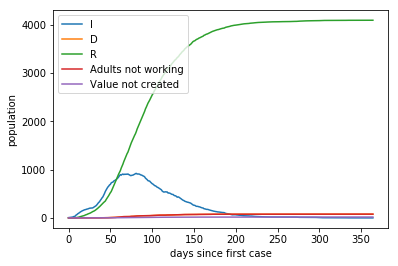

In [18]:
#We put 5 infected in a untouched country which take no counter-mesure for a year
m = Basic_SIR_Model(G)
m.basic_scenario()



## Basic counter-mesure: Killing the sick preventivelly

first I try something very basic and cruel: The state kills every infected it can find. 
I suppose that the state take action once 200 people are infected. (time to discover there existence)
I suppose they can test everybody but with a technology that is not very reliable 0.3 chance to discover the virus and no false positive.
The results are not great at all, the virus still spreads but is now indirectly way worst

first infected are:
Person #3884
Person #9576
Person #8672
Person #3423
Person #6276
64  killed during search
61  killed during search
54  killed during search
61  killed during search
67  killed during search
63  killed during search
65  killed during search
75  killed during search
63  killed during search
69  killed during search
70  killed during search
55  killed during search
62  killed during search
61  killed during search
66  killed during search


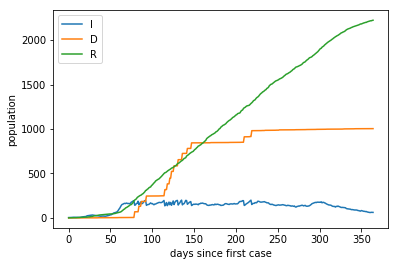

In [19]:
# we try to kill every infected once we discover them
class North_Korea(Basic_SIR_Model):
    def __init__(self,G):
        super().__init__(G)
        self.execution_proba = 0.3 #chance to be caught and executed if you are sick during a search
    
    def search(self): 
        nb_killed = 0
        for node in list(self.G.nodes()):
            if(node.state == "I"): 
                r = random.random()
                if r < self.execution_proba: #we try to kill the infected quickly
                    node.state = "D"
                    nb_killed +=1
        print(nb_killed," killed during search")
    
    def basic_scenario(self): 
        self.initialize_patients_zero(number_of_first_cases=5)
        for i in range(365):
            self.one_normal_day_passes()
            nb_infected = len([nd for nd in list(self.G.nodes) if nd.state == "I" ])   
            if nb_infected > 200 :
                m.search()
            self.store_infection_state_pop()
            self.day+=1
        self.plot_hist()



m = North_Korea(G)
m.basic_scenario()
        
        

# Basic counter-mesure: sick leave

People are allowed to take sick leave if they have the symptoms. Everyday if you have the symptoms you have a chance to notice them and to stop working until death or recovery. During that time, the node will only be in contact with its houshold.

first infected are:
Person #6152
Person #2902
Person #451
Person #5427
Person #813
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Construction
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Shops_other

Transportation
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
nan
<class 'str'>
Construction
<class 'str'>
Services_other
<class 'str'>
Construction
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<cla

<class 'str'>
Transportation
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Hotel_Restaurant
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Construction
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Administ

Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Health
<class 'str'>
Shops_other
<class 'str'>
nan
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Shops_market_food
<class 'str'>
Indus_other
<class 'str

<class 'str'>
Hotel_Restaurant
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Hotel_Restaurant
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_food
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Hotel_Restaurant
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>


Administration_schools
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Services_other
<class 'str'>
Indus_oth

Administration_schools
<class 'str'>
Hotel_Restaurant
<class 'str'>
Hotel_Restaurant
<class 'str'>
Shops_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'

Indus_food
<class 'str'>
Indus_food
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Transportation
<class 'str'>
Construction
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Agriculture_fishing
<class 'str'>
Administration_schools
<cl

Indus_other
<class 'str'>
Indus_food
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Construction
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Hotel_Restaurant
<class 'str'>
Services_other
<class 'str'>
n

Services_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Hotel_Restaurant
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Indus_fo

Indus_food
<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Construction
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Health
<class 'str'>
Indus_fo

Indus_food
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Hotel_Restaurant
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Construction
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<clas

Hotel_Restaurant
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Shops_other
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<clas

<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Shops_other


Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Admin

<class 'str'>
Indus_food
<class 'str'>
Hotel_Restaurant
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Shops_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class

<class 'str'>
Health
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Hotel_Restaurant
<class 'str'>
nan
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Indus_food
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Indus_food
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 

Administration_schools
<class 'str'>
Health
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
nan
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools


Hotel_Restaurant
<class 'str'>
Indus_food
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Hotel_Restaurant
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Services_other
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<

Administration_schools
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Hotel_Restaurant
<class 'str'>
Shops_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
n

<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Indus_food
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Hotel_Restaurant
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Adm

Hotel_Restaurant
<class 'str'>
Indus_food
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Hotel_Restaurant
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Services_other
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Administration_sc

Indus_food
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Services_other
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_food
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class

Indus_food
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Services_other
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>


Health
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Indus_food
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Indus_food
<class 'str'>
Admini

Indus_food
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools


<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Construction
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_fo

Indus_food
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Agriculture_fishing
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<clas

Indus_food
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Agriculture_fishing
<class 'str'>
Administration_schools
<class

<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<c

Indus_food
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Agriculture_fishing
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Services_other
<class 'str'>
I

Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Agriculture_fishing
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str

Agriculture_fishing
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
Indus_food
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Shops_market_food
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Hotel_Restaurant
<class 'str'

<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Shops_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Construction
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Agriculture_fishing
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Indus_food
<class 'str'>
nan
<class 'str'>
Services_other
<class 'str'>
Health
<class 'str'

Hotel_Restaurant
<class 'str'>
Hotel_Restaurant
<class 'str'>
Health
<class 'str'>
Shops_other
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
Indus_food
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Transportation
<class 'str'>
Transportation
<clas

<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Health
<class 'str'>
Shops_other
<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Agriculture_fishing
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
nan
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 's

Indus_food
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indu

Indus_food
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Hotel_Restaurant


<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
Indus_food
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Agriculture_fishing
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Agriculture_fishing
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_market_food
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 

Services_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Hotel_Restaurant
<class 'str'>
nan
<class 'str'>
Transportation
<class 'str'>
Hotel_Restaurant
<class 'str'>
Health
<class 'str'>
Shops_other
<class 'str'>
Services_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Services_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<cla

<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Shops_other
<class 'str'>
nan
<class 'str'>
Agriculture_fishing
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Construction
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Ind

Services_other
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_other
<class 'str'>
nan
<c

Services_other
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Construction
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Adm

<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Construction
<clas

<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Construction
<class 'str'>
Agriculture_fishing
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Agriculture_fishing
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_market_food
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Services_other
<class 'str'>
Administr

Services_other
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Construction

<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Services_other
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Hotel_Restaurant
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Constructio

Services_other
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>

Shops_other
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
Administration_schools
<class

Shops_other
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Cons

Shops_other
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 's

<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
Hotel_Restaurant
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Hotel_Restaurant
<class 'str'>
Shops_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>


Shops_other
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Con

<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Agriculture_fishing
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Agriculture_fishing
<class 'str'>
Construction
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Shops_other
<class 'str'>
Administration_

<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Agriculture_fishing
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Indus_other
<c

Shops_other
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Administration_schools
<class

<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Agriculture_fishing
<class 'str'>
Services_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Hotel_Restaurant
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
n

Shops_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Admin

<class 'str'>
Agriculture_fishing
<class 'str'>
Transportation
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_market_food
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Agriculture_fishing
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_food
<class 'str'>
Shops_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 

<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Transportation
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_market_food
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Agriculture_fishing
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_food
<class 'str'>
Shops_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Shops_o

Shops_market_food
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Shops_other
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Construction
<cl

Services_other
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
nan
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'

Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_market_food
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
Shops_other
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
Hotel_Restaurant
<class 'str'>
Administration_schools
<class 'str'>
Indus_ot

Services_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_market_food
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_food
<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Health
<clas

Agriculture_fishing
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_market_food
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_food
<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Construction
<class 'str'>
Health
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<

<class 'str'>
Construction
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Shops_other
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
nan
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
n

Administration_schools
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<cla

<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Agriculture_fishing
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Shops_other
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administ

Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Shops_market_food
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'st

Shops_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Agriculture_fishing
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Shops_other
<class 'str'>
Construction
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>

<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Shops_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Shops_other
<class 'str'>
Construction
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Shops_market_food
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Administration_sch

Services_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Agriculture_fishing
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Shops_other
<class 'str'>
Construction
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'

Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<

Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Shops_market_food
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Administratio

<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administ

<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
H

Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Sh

Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Shops_market_food
<c

<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Services_o

Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Shops_market_food
<c

Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Shops_market_food
<class 'str'>
Health
<class 

Indus_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Administration_scho

<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Shops_market_food
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'

Construction
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_other
<class 'str'>
Indus_food
<class 'str'>
Administration_schools
<class 'str'>
Shops_market_food
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
nan
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Indus_other
<class 'str'>
Agriculture_fishing
<class 'str'>
Indus_food
<class 'str'>
Health
<class 'str'>
nan
<class 'str'>
Indus_other
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Services_oth

Administration_schools
<class 'str'>
Construction
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
Services_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Health
<class 'str'>
Transportation
<class 'str'>
Health
<class 'str'>
Administration_schools
<class 'str'>
Administration_schools
<class 'str'>
Transportation
<class 'str'>
nan
<class 'str'>
Administration_schools
<class 'str'>
Construction
<class 'str'>
Administration_schools
<class 'str'>
Indus_other
<class 'str'>
Services_other
<class 'str'>
Administration_schools
<class 'str'>
Services_other
<class 'str'>
Shops_other
<class 'str'>
Administration_schools
<class 'str'>
Shops_other
<class 'str'>
Indus_

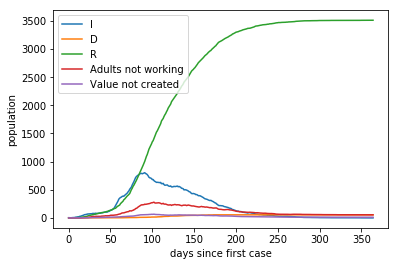

In [20]:
class Sick_leave_scenario(Basic_SIR_Model):
    def __init__(self,G):
        super().__init__(G)
        self.sickness_awarness = 0.03 #daily probability of noticing you are infected
    
    def one_normal_day_passes(self): #same but sick leave exists now
        
        changing_state = dict() # store the nodes that change state before updating them all at once
        for state in self.infection_states:
            changing_state[state]= []

        for node in list(self.G.nodes()):
            if node.state == "I":  #for every infected people
                if (type(node) == Adult and not node.working): #people on sick leave
                    for neig in self.G[node]: 
                        if neig.state == "S":
                            t = self.G[node][neig]['type']
                            if  t == "household" and self.interaction(t): #no contact with co workers
                                changing_state["I"].append(neig) #new infected :'(    
                else: # childrens and working people
                    #we try each possible infection
                    for neig in self.G[node]: 
                        if neig.state == "S":
                            t = self.G[node][neig]['type']
                            if self.interaction(t):
                                changing_state["I"].append(neig) #new infected :'(         
                #we check if the condition of the sick change (death recovery or no change)
                new_state = self.sickness_evolution(node.age) 
                if new_state != node.state : 
                    changing_state[new_state].append(node)
                    
                #Sick adults may take a sick leave if they notice the syptomes
                if (type(node) == Adult and node.working): #people take sick leave
                    node.working = (random.random() >= self.sickness_awarness )

                    
        for state in self.infection_states: #update all the nodes states at once after all the interactions
            for node in changing_state[state]:
                node.state = state
                #for now sick people work because this scenario is low-key distopian
                if(state == "D" and type(node) == Adult): 
                    node.working = False #dead people don't work :'(
                
                if(state == "R" and type(node) == Adult): #sick leave ends
                    node.working = True
                
    
m = Sick_leave_scenario(G)
m.basic_scenario()
        

In [21]:
m.hist["Value not created"]

[[0, 0],
 [0, 1],
 [0, 2],
 [0, 3],
 [0, 4],
 [0, 5],
 [0, 6],
 [0, 7],
 [0, 8],
 [0, 9],
 [0, 10],
 [0, 11],
 [0, 12],
 [0.56, 13],
 [0.56, 14],
 [1.12, 15],
 [1.6800000000000002, 16],
 [1.2400000000000002, 17],
 [2.3600000000000003, 18],
 [3.14, 19],
 [3.2, 20],
 [2.7600000000000002, 21],
 [2.7600000000000002, 22],
 [2.7600000000000002, 23],
 [3.000000000000001, 24],
 [3.340000000000001, 25],
 [3.9000000000000012, 26],
 [5.080000000000001, 27],
 [6.580000000000001, 28],
 [7.0200000000000005, 29],
 [6.960000000000002, 30],
 [7.400000000000001, 31],
 [7.84, 32],
 [8.020000000000001, 33],
 [7.920000000000003, 34],
 [8.040000000000003, 35],
 [8.040000000000001, 36],
 [8.66, 37],
 [8.540000000000001, 38],
 [9.299999999999997, 39],
 [9.52, 40],
 [9.959999999999999, 41],
 [9.959999999999999, 42],
 [10.18, 43],
 [10.68, 44],
 [11.020000000000001, 45],
 [10.360000000000001, 46],
 [11.920000000000003, 47],
 [10.800000000000002, 48],
 [12.260000000000002, 49],
 [13.540000000000003, 50],
 [14.10